## HW 2 - Machine Learning in Finance

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from multiprocessing import Pool
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv('../config.env')

# impoting tools and packages from mfinlab
from mlfinlab.util.volatility import get_daily_vol
from mlfinlab.filters.filters import cusum_filter
from mlfinlab.labeling import labeling


In [2]:
# importing data from Data directory
df = pd.read_csv('../Data/dollar_bars.csv')

# turning 'data_time' column into datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# setting the 'date_time' column as the index
df.set_index('date_time', inplace=True)


In [3]:
# checking the first few rows of the data
df.head()


,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332


In [4]:
# getting the summary statistics of the data
df.describe()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
count,24079.000000,24079.000000,24079.000000,24079.000000,24079.000000,2.407900e+04,24079.000000
mean,2061.119544,2063.036515,2059.207286,2061.126864,34064.460941,7.007916e+07,4782.275967
std,88.684146,88.161108,89.206479,88.690949,1494.343678,1.468380e+05,2752.484944
min,1805.500000,1808.000000,1802.500000,1805.750000,30830.000000,7.000000e+07,535.000000
25%,2013.750000,2016.000000,2011.500000,2013.750000,33148.000000,7.000528e+07,3189.500000
50%,2073.250000,2074.750000,2071.250000,2073.250000,33810.000000,7.002371e+07,3900.000000
75%,2114.250000,2115.750000,2112.750000,2114.250000,34786.000000,7.008734e+07,5160.500000
max,2272.000000,2273.000000,2271.250000,2272.000000,38929.000000,7.317989e+07,19342.000000


### Visualizing Price Data over Time

/Users/karolk/anaconda3/envs/ML_Fin/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_42767/4039407809.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


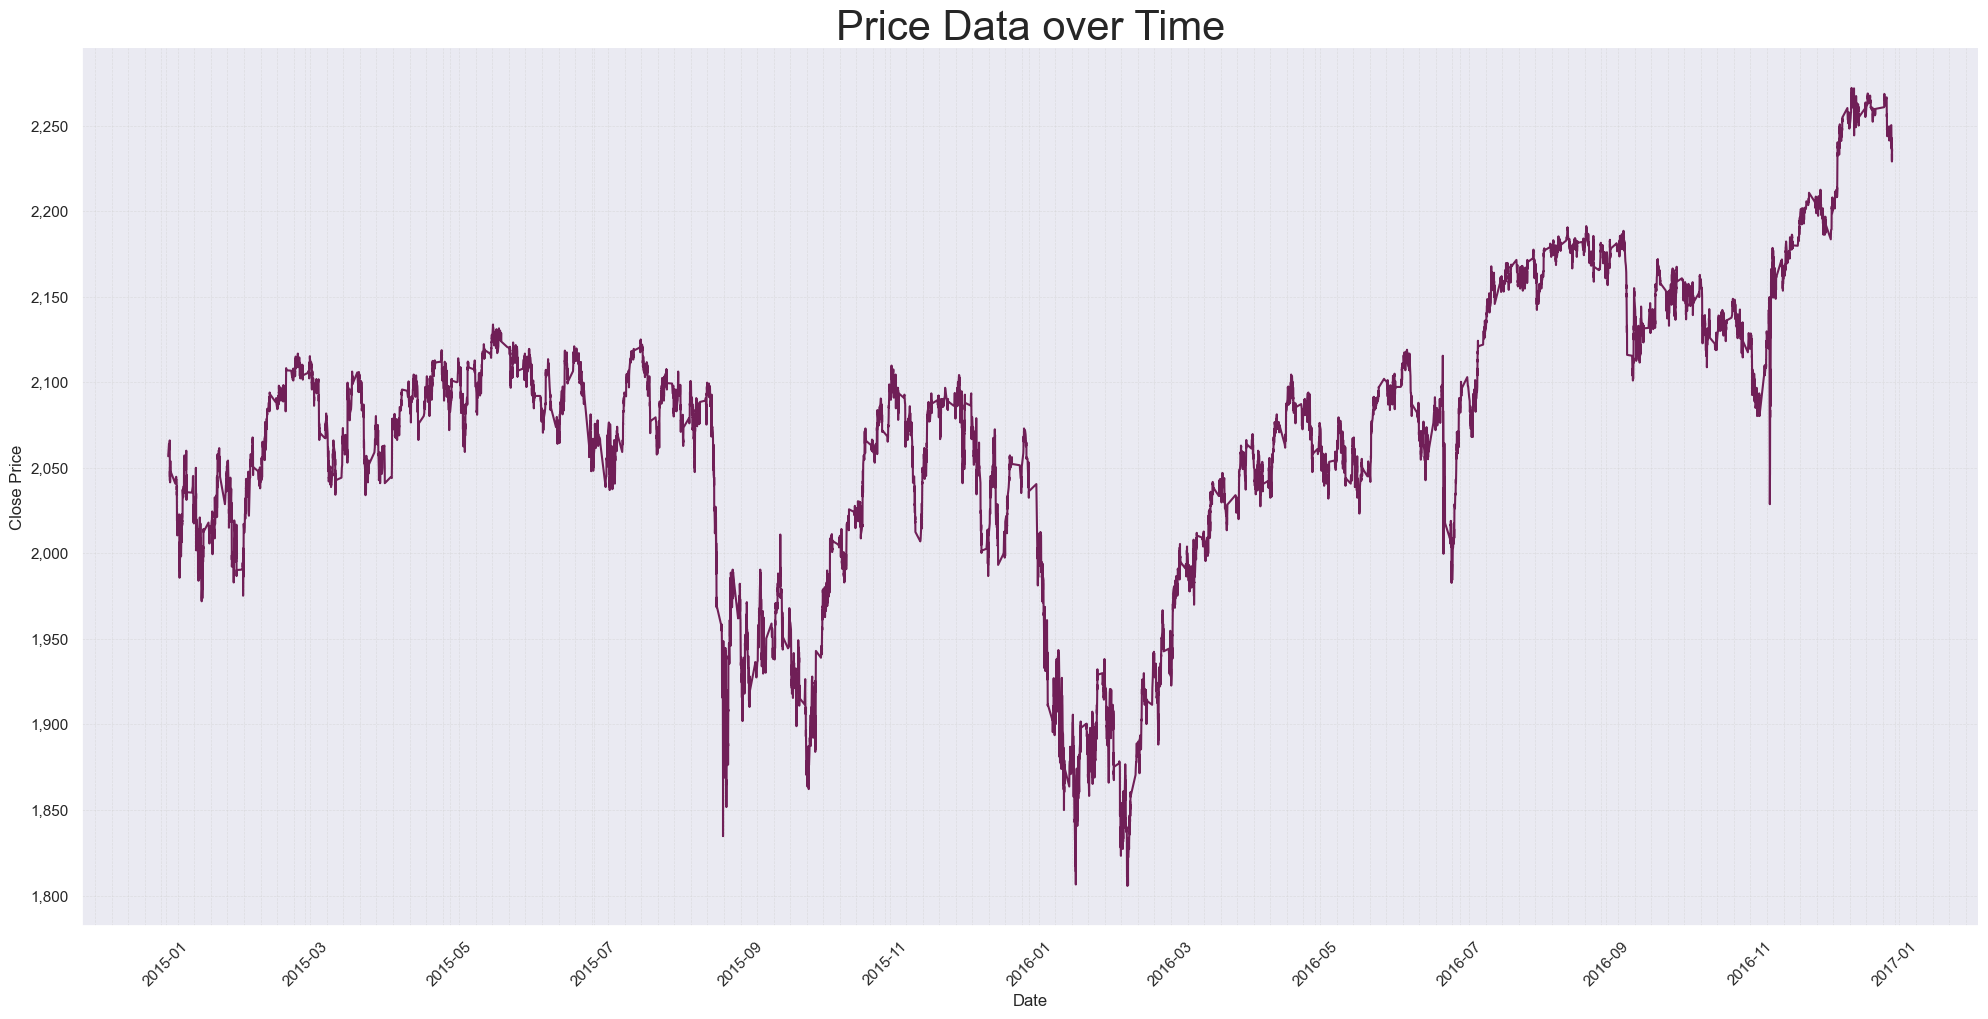

In [5]:
# plotting the price data over time

# setting the style and palette
sns.set_context('notebook')
sns.set_style('darkgrid')
sns.set_palette('rocket')

# selecting color from the palette
line_color = sns.color_palette()[1]


# plotting the price data over time
sns.relplot(x='date_time', y='close', data=df, kind='line', color=line_color)

# Changing the size of the plot
plt.gcf().set_size_inches(20, 10)

# adding title
plt.title('Price Data over Time', fontsize=30)

# setting layout as tight
plt.tight_layout()

# rotating the x-axis labels and y-axis labels
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')

# adding more x and y labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# adding more y labels
plt.locator_params(axis='y', nbins=20)

# adding comma separator to y labels
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# adding more gridlines
plt.grid(which='both', axis='both', linestyle='--', alpha=0.6, color='lightgrey', linewidth=0.5)

# displaying the plot
plt.show()

# closing the plot
plt.close()


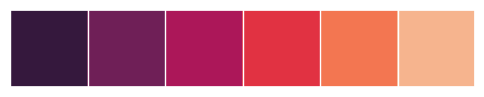

In [6]:
# Get the 'rocket' palette
palette = sns.color_palette('rocket')

# Plot the colors in the palette
sns.palplot(palette)
plt.show()

#### Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).

In [7]:
# Compute daily volatility
vol = get_daily_vol(close=df['close'], lookback=50)

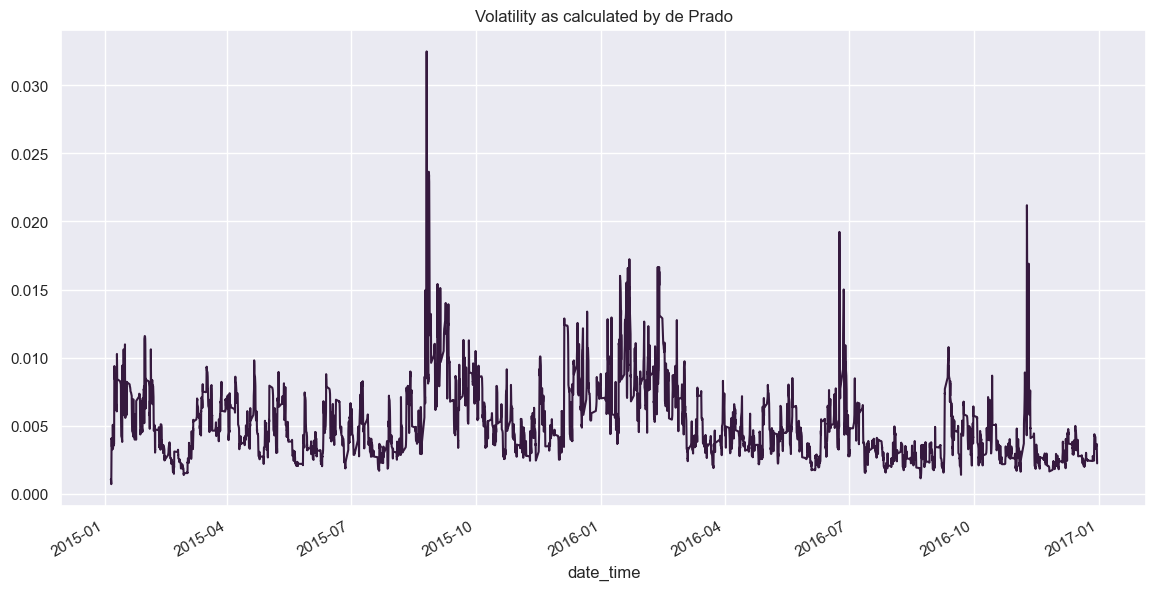

In [8]:
# checking the daily volatility
vol.plot(figsize=(14, 7), title='Volatility as calculated by de Prado')
plt.show()

In [9]:
# Apply Symmetric CUSUM filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = cusum_filter(df['close'], threshold=vol.mean())

In [10]:
# checking the cusum events
cusum_events[:5]

DatetimeIndex(['2015-01-02 15:39:14.826000', '2015-01-02 20:47:02.488000',
               '2015-01-04 23:20:12.567000', '2015-01-05 14:49:36.175000',
               '2015-01-05 16:10:05.172000'],
              dtype='datetime64[ns]', freq=None)

#### Use Snippet 3.4 on a pandas series t1, where numDays=1.

In [11]:
# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(cusum_events, df['close'],num_days=1)
vertical_barriers.head(25)

2015-01-02 15:39:14.826   2015-01-04 23:20:12.567
2015-01-02 20:47:02.488   2015-01-04 23:20:12.567
2015-01-04 23:20:12.567   2015-01-06 02:16:54.528
2015-01-05 14:49:36.175   2015-01-06 14:52:04.655
2015-01-05 16:10:05.172   2015-01-06 16:11:27.929
2015-01-05 19:53:07.211   2015-01-06 19:53:58.683
2015-01-06 15:22:16.841   2015-01-07 15:26:31.254
2015-01-06 15:57:59.243   2015-01-07 15:58:47.211
2015-01-06 16:35:18.127   2015-01-07 16:38:30.780
2015-01-06 18:20:27.201   2015-01-07 18:35:53.614
2015-01-06 19:32:17.786   2015-01-07 19:39:58.897
2015-01-06 20:59:59.035   2015-01-07 21:00:13.228
2015-01-07 10:55:23.194   2015-01-08 11:20:19.427
2015-01-07 15:40:41.713   2015-01-08 15:45:22.717
2015-01-07 16:59:48.815   2015-01-08 17:00:01.061
2015-01-08 01:48:57.964   2015-01-09 07:30:41.047
2015-01-08 15:00:21.581   2015-01-09 15:02:59.709
2015-01-08 19:39:36.101   2015-01-09 19:52:45.368
2015-01-09 14:57:41.810   2015-01-11 23:31:19.054
2015-01-09 15:32:41.582   2015-01-11 23:31:19.054


#### On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.


In [12]:
triple_barrier_events = labeling.get_events(close=df['close'],
                                            t_events=cusum_events,
                                            pt_sl=[1, 1],
                                            target=vol,
                                            num_threads=1,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=None)

In [13]:
# checking the triple barrier events
triple_barrier_events.head(25)

,t1,trgt,pt,sl
2015-01-05 14:49:36.175,2015-01-05 15:01:57.494,0.001968,1,1
2015-01-05 16:10:05.172,2015-01-05 18:06:47.164,0.003405,1,1
2015-01-05 19:53:07.211,2015-01-06 12:05:40.394,0.004073,1,1
2015-01-06 15:22:16.841,2015-01-06 15:50:10.601,0.004686,1,1
2015-01-06 15:57:59.243,2015-01-06 16:30:23.053,0.005000,1,1
2015-01-06 16:35:18.127,2015-01-06 17:09:12.134,0.004391,1,1
2015-01-06 18:20:27.201,2015-01-06 19:03:11.469,0.003753,1,1
2015-01-06 19:32:17.786,2015-01-06 19:53:58.683,0.003334,1,1
2015-01-06 20:59:59.035,2015-01-07 10:55:23.194,0.003878,1,1
2015-01-07 10:55:23.194,2015-01-07 15:02:09.044,0.003695,1,1


In [14]:
# generating labels
labels = labeling.get_bins(triple_barrier_events, df['close'])

# checking the labels
labels.head(25)

,ret,trgt,bin
2015-01-05 14:49:36.175,-0.002952,0.001968,-1
2015-01-05 16:10:05.172,-0.003463,0.003405,-1
2015-01-05 19:53:07.211,0.004850,0.004073,1
2015-01-06 15:22:16.841,-0.005315,0.004686,-1
2015-01-06 15:57:59.243,-0.005097,0.005000,-1
2015-01-06 16:35:18.127,-0.004626,0.004391,-1
2015-01-06 18:20:27.201,0.003899,0.003753,1
2015-01-06 19:32:17.786,0.004131,0.003334,1
2015-01-06 20:59:59.035,0.006390,0.003878,1
2015-01-07 10:55:23.194,0.004856,0.003695,1


In [15]:
# checking the value counts of the labels
labels['bin'].value_counts()

bin
 1    634
-1    615
 0    272
Name: count, dtype: int64

#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [16]:
# dropping rare labels
clean_labels = labeling.drop_labels(labels)

In [17]:
print(labels.shape)
print(clean_labels.shape)


(1521, 3)
(1521, 3)


In [18]:
# viewing the clean labels
clean_labels.head(25)

,ret,trgt,bin
2015-01-05 14:49:36.175,-0.002952,0.001968,-1
2015-01-05 16:10:05.172,-0.003463,0.003405,-1
2015-01-05 19:53:07.211,0.004850,0.004073,1
2015-01-06 15:22:16.841,-0.005315,0.004686,-1
2015-01-06 15:57:59.243,-0.005097,0.005000,-1
2015-01-06 16:35:18.127,-0.004626,0.004391,-1
2015-01-06 18:20:27.201,0.003899,0.003753,1
2015-01-06 19:32:17.786,0.004131,0.003334,1
2015-01-06 20:59:59.035,0.006390,0.003878,1
2015-01-07 10:55:23.194,0.004856,0.003695,1


#### 3.3 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side but not a size of the bet.


##### Moving Average Strategy: Developing Labels

In [19]:
# creating a copy of the data
data = df.copy()

# creating a 50-day simple moving average column in the data
data['SMA50'] = data['close'].rolling(window=50).mean()

# creating a new column with 1s and -1s based on the condition that the close price is greater than the 50-day moving average or not. If the close price is greater than the 50-day moving average, the value is 1, otherwise -1.
data['side'] = np.where(data['close'] > data['SMA50'], 1, -1)

# drop any SMA columns with NaN values
data.dropna(subset=['SMA50'], inplace=True)

# checking the first few rows of the data
data.head(25)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,SMA50,side
date_time,,,,,,,,,
2015-01-05 14:40:42.612,2037.00,2037.25,2033.50,2034.00,34412,70032398.00,11769,2049.365,-1
2015-01-05 14:44:56.036,2034.00,2036.50,2032.50,2036.25,34414,70002162.00,12282,2048.955,-1
2015-01-05 14:49:36.175,2036.25,2036.75,2031.75,2032.50,34429,70021162.50,12699,2048.325,-1
2015-01-05 14:54:26.286,2032.50,2033.00,2030.00,2030.25,34478,70028368.50,11202,2047.720,-1
2015-01-05 14:57:13.616,2030.25,2030.50,2027.25,2029.25,34511,70008424.25,10941,2047.085,-1
2015-01-05 15:01:57.494,2029.25,2029.75,2025.50,2026.50,34525,70002144.25,12045,2046.340,-1
2015-01-05 15:07:29.012,2026.50,2029.75,2025.75,2029.25,34514,70008196.00,12257,2045.635,-1
2015-01-05 15:13:09.655,2029.25,2031.25,2027.25,2028.25,34493,70002290.25,12276,2044.880,-1
2015-01-05 15:22:28.576,2028.25,2030.25,2026.75,2028.00,34513,70000075.75,13083,2044.170,-1


In [20]:
# computing the daily volatility of the data['close'] column as some data was dropped
vol_MA_strat = get_daily_vol(close=data['close'], lookback=50)


In [21]:
# applying the symmetric CUSUM filter on the data using the daily volatility from the moving average strategy
threshold = vol_MA_strat.mean()

# Apply Symmetric CUSUM filter and get timestamps for events
cusum_events_MA_strat = cusum_filter(data['close'], threshold=threshold)

In [22]:
# computing the vertical barriers for the moving average strategy
vertical_barriers_MA_strat = labeling.add_vertical_barrier(cusum_events_MA_strat, data['close'], num_days=1)

In [23]:
# applying the triple barrier method on the moving average strategy
triple_barrier_events_MA_strat = labeling.get_events(close=data['close'],
                                                      t_events=cusum_events_MA_strat,
                                                      pt_sl=[1, 2],
                                                      target=vol_MA_strat,
                                                      num_threads=1,
                                                      vertical_barrier_times=vertical_barriers_MA_strat,
                                                      side_prediction=data['side'])

# viewing the triple barrier events for the moving average strategy
triple_barrier_events_MA_strat.head(25)

,t1,trgt,side,pt,sl
2015-01-06 15:22:16.841,2015-01-06 15:50:10.601,0.002619,1,1,2
2015-01-06 15:57:59.243,2015-01-06 16:04:42.703,0.002100,-1,1,2
2015-01-06 16:35:18.127,2015-01-06 16:44:48.791,0.002371,-1,1,2
2015-01-06 18:20:27.201,2015-01-06 19:48:26.783,0.003538,-1,1,2
2015-01-06 19:32:17.786,2015-01-07 13:06:58.746,0.003095,-1,1,2
2015-01-06 20:59:59.035,2015-01-07 13:06:58.746,0.003587,-1,1,2
2015-01-07 10:55:23.194,2015-01-07 15:02:09.044,0.003405,1,1,2
2015-01-07 15:40:41.713,2015-01-07 16:55:16.638,0.003808,1,1,2
2015-01-07 16:59:48.815,2015-01-08 01:48:57.964,0.006524,1,1,2
2015-01-08 01:48:57.964,2015-01-08 18:11:19.540,0.008445,1,1,2


In [24]:
# generating labels for the moving average strategy
labels_MA_strat = labeling.get_bins(triple_barrier_events_MA_strat, data['close'])

# checking the labels for the moving average strategy
labels_MA_strat.head(25)

,ret,trgt,bin,side
2015-01-06 15:22:16.841,-0.005315,0.002619,0,1
2015-01-06 15:57:59.243,0.002238,0.002100,1,-1
2015-01-06 16:35:18.127,0.002500,0.002371,1,-1
2015-01-06 18:20:27.201,-0.007295,0.003538,0,-1
2015-01-06 19:32:17.786,-0.006760,0.003095,0,-1
2015-01-06 20:59:59.035,-0.007643,0.003587,0,-1
2015-01-07 10:55:23.194,0.004856,0.003405,1,1
2015-01-07 15:40:41.713,0.005358,0.003808,1,1
2015-01-07 16:59:48.815,0.009414,0.006524,1,1
2015-01-08 01:48:57.964,0.009081,0.008445,1,1


In [25]:
# creating a matrix to better understand the labels. The x will be the bin and the y will be the side
pd.crosstab(labels_MA_strat['bin'], labels_MA_strat['side'])

# note to self: Side give guidance whether to go long or short. Bin is a one if the trade is profitable, meaning above the target, and zero if it is not profitable, meaning below the target.

side,-1,1
bin,,
0,420,405
1,366,324


In [26]:
# dropping rare labels for the moving average strategy
clean_labels_MA_strat = labeling.drop_labels(labels_MA_strat)

# checking the shape of the labels and the clean labels
print(labels_MA_strat.shape)
print(clean_labels_MA_strat.shape)


(1515, 4)
(1515, 4)


In [27]:
# viewing the clean labels for the moving average strategy
clean_labels_MA_strat.head(25)


,ret,trgt,bin,side
2015-01-06 15:22:16.841,-0.005315,0.002619,0,1
2015-01-06 15:57:59.243,0.002238,0.002100,1,-1
2015-01-06 16:35:18.127,0.002500,0.002371,1,-1
2015-01-06 18:20:27.201,-0.007295,0.003538,0,-1
2015-01-06 19:32:17.786,-0.006760,0.003095,0,-1
2015-01-06 20:59:59.035,-0.007643,0.003587,0,-1
2015-01-07 10:55:23.194,0.004856,0.003405,1,1
2015-01-07 15:40:41.713,0.005358,0.003808,1,1
2015-01-07 16:59:48.815,0.009414,0.006524,1,1
2015-01-08 01:48:57.964,0.009081,0.008445,1,1


##### Moving Average Strategy: Developing Features and Fitting a Model

In [28]:
# merging data with the clean labels using the index in both dataframes
data = data.merge(clean_labels_MA_strat, how='inner', left_index=True, right_index=True)

# dropping side_x column as it is not needed and renaming side_y to side
data.drop(columns='side_x', inplace=True)
data.rename(columns={'side_y': 'side'}, inplace=True)


In [29]:
# checking the first few rows of the data
data.head(25)


,open,high,low,close,cum_vol,cum_dollar,cum_ticks,SMA50,ret,trgt,bin,side
2015-01-06 15:22:16.841,2021.50,2023.25,2020.25,2022.75,34687,70128994.75,10609,2016.465,-0.005315,0.002619,0,1
2015-01-06 15:57:59.243,2012.00,2013.75,2010.00,2011.00,34904,70223126.25,11299,2015.885,0.002238,0.002100,1,-1
2015-01-06 16:35:18.127,2000.75,2002.50,1999.00,1999.75,34995,70009303.00,10404,2013.960,0.002500,0.002371,1,-1
2015-01-06 18:20:27.201,1990.50,1992.00,1986.75,1987.75,35192,70001527.50,11589,2007.865,-0.007295,0.003538,0,-1
2015-01-06 19:32:17.786,1993.25,1998.50,1992.50,1997.00,35071,70000051.00,10471,2004.015,-0.006760,0.003095,0,-1
2015-01-06 20:59:59.035,1996.25,1996.75,1994.25,1995.25,35083,70002683.25,8865,2000.095,-0.007643,0.003587,0,-1
2015-01-07 10:55:23.194,1998.25,2008.00,1997.00,2008.00,34942,70000565.25,14241,1997.795,0.004856,0.003405,1,1
2015-01-07 15:40:41.713,2009.00,2013.25,2006.00,2006.50,34877,70111070.25,13191,2001.275,0.005358,0.003808,1,1
2015-01-07 16:59:48.815,2017.25,2019.25,2016.25,2018.25,34704,70025453.25,9995,2005.185,0.009414,0.006524,1,1
2015-01-08 01:48:57.964,2021.50,2038.25,2021.00,2037.25,34490,70003975.75,16212,2014.660,0.009081,0.008445,1,1


##### Fitting a Model: Steps
1. Create a smaller dataset with only the features and labels (X and y). Create a variable called columns2keep which will be a list of columns to keep.
2. Add new features such as percentage changes in values, moving averages, and lag variables.
3. Perform high-level visualizations of the data to inspect relationships and distributions.
4. Pre-process the data by filling missing values and normalizing the data. **[for forest based models scaling is not necessary]**
5. Split the data into training and testing datasets.
6. Fit a model on the training dataset.
7. Evaluate the model on the testing dataset by creating a confusion matrix and calculating the accuracy. **[do a nice visualization]**
8. Check for feature importance. **[do a nice visualization]**
9. Perform hyperparameter tuning.

In [30]:
# listing all the columns in the data
data.columns

Index(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks',
       'SMA50', 'ret', 'trgt', 'bin', 'side'],
      dtype='object')

In [31]:
# creating a list of columns to keep

# columns to keep
columns2keep = ['open', 'high' ,'low','close', 'SMA50', 'side', 'bin']

# creating a smaller dataset with only the features and labels
data_ml = data[columns2keep]

# checking the first few rows of the data_ml
data_ml.head(25)


,open,high,low,close,SMA50,side,bin
2015-01-06 15:22:16.841,2021.50,2023.25,2020.25,2022.75,2016.465,1,0
2015-01-06 15:57:59.243,2012.00,2013.75,2010.00,2011.00,2015.885,-1,1
2015-01-06 16:35:18.127,2000.75,2002.50,1999.00,1999.75,2013.960,-1,1
2015-01-06 18:20:27.201,1990.50,1992.00,1986.75,1987.75,2007.865,-1,0
2015-01-06 19:32:17.786,1993.25,1998.50,1992.50,1997.00,2004.015,-1,0
2015-01-06 20:59:59.035,1996.25,1996.75,1994.25,1995.25,2000.095,-1,0
2015-01-07 10:55:23.194,1998.25,2008.00,1997.00,2008.00,1997.795,1,1
2015-01-07 15:40:41.713,2009.00,2013.25,2006.00,2006.50,2001.275,1,1
2015-01-07 16:59:48.815,2017.25,2019.25,2016.25,2018.25,2005.185,1,1
2015-01-08 01:48:57.964,2021.50,2038.25,2021.00,2037.25,2014.660,1,1


In [32]:
# adding new features to the data_ml

# adding percentage changes in values: open, high, low, close
data_ml.loc[:, 'open_pct_change'] = data_ml['open'].pct_change()
data_ml.loc[:, 'high_pct_change'] = data_ml['high'].pct_change()
data_ml.loc[:, 'low_pct_change'] = data_ml['low'].pct_change()
data_ml.loc[:, 'close_pct_change'] = data_ml['close'].pct_change()

# adding moving averages for close price, in addition to the 50-day moving average I will evaluate the 100-day and 200-day moving averages
data_ml.loc[:, 'SMA100'] = data_ml['close'].rolling(window=100).mean()
data_ml.loc[:, 'SMA200'] = data_ml['close'].rolling(window=200).mean()

# adding lag variables for the close price and open price. I will evaluate the 1-day and 2-day lag variables
data_ml.loc[:, 'close_lag1'] = data_ml['close'].shift(1)
data_ml.loc[:, 'close_lag2'] = data_ml['close'].shift(2)
data_ml.loc[:, 'open_lag1'] = data_ml['open'].shift(1)
data_ml.loc[:, 'open_lag2'] = data_ml['open'].shift(2)

# dropping any rows with NaN values
data_ml.dropna(inplace=True)

# checking the first few rows of the data_ml
data_ml.head(25)


/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_42767/2636021037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml.loc[:, 'open_pct_change'] = data_ml['open'].pct_change()
/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_42767/2636021037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml.loc[:, 'high_pct_change'] = data_ml['high'].pct_change()
/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_42767/2636021037.py:6: SettingWithCopyWarning: 
A value is trying t

,open,high,low,close,SMA50,side,bin,open_pct_change,high_pct_change,low_pct_change,close_pct_change,SMA100,SMA200,close_lag1,close_lag2,open_lag1,open_lag2
2015-04-22 17:38:55.488,2097.50,2098.50,2096.00,2097.75,2092.705,1,1,0.005272,0.001312,0.004553,0.000954,2071.5525,2043.37125,2095.75,2083.25,2086.50,2097.75
2015-04-23 07:36:08.132,2097.00,2099.00,2090.50,2091.00,2093.740,-1,0,-0.000238,0.000238,-0.002624,-0.003218,2072.2425,2043.71250,2097.75,2095.75,2097.50,2086.50
2015-04-23 14:01:48.425,2099.50,2102.50,2099.25,2102.25,2094.605,1,1,0.001192,0.001667,0.004186,0.005380,2072.9325,2044.16875,2091.00,2097.75,2097.00,2097.50
2015-04-23 16:37:49.972,2107.50,2111.00,2107.00,2110.50,2098.510,1,0,0.003810,0.004043,0.003692,0.003924,2073.5825,2044.72250,2102.25,2091.00,2099.50,2097.00
2015-04-27 11:15:46.650,2112.75,2118.00,2111.00,2116.00,2110.285,1,0,0.002491,0.003316,0.001898,0.002606,2074.1775,2045.36375,2110.50,2102.25,2107.50,2099.50
2015-04-27 16:53:02.989,2109.00,2109.50,2105.50,2105.75,2111.775,-1,1,-0.001775,-0.004013,-0.002605,-0.004844,2074.5750,2045.90750,2116.00,2110.50,2112.75,2107.50
2015-04-28 11:36:14.579,2100.00,2101.50,2095.25,2096.25,2109.625,-1,0,-0.004267,-0.003792,-0.004868,-0.004511,2075.0000,2046.41250,2105.75,2116.00,2109.00,2112.75
2015-04-28 14:15:16.614,2092.75,2093.00,2088.25,2089.25,2106.155,-1,0,-0.003452,-0.004045,-0.003341,-0.003339,2075.4200,2046.81875,2096.25,2105.75,2100.00,2109.00
2015-04-28 15:02:02.685,2100.50,2101.50,2098.50,2101.50,2103.365,-1,0,0.003703,0.004061,0.004908,0.005863,2076.0550,2047.29375,2089.25,2096.25,2092.75,2100.00
2015-04-29 12:41:24.934,2104.00,2104.25,2099.00,2100.25,2102.810,-1,0,0.001666,0.001309,0.000238,-0.000595,2076.4975,2047.70375,2101.50,2089.25,2100.50,2092.75


In [33]:
# getting list of columns in the data_ml
data_ml.columns



Index(['open', 'high', 'low', 'close', 'SMA50', 'side', 'bin',
       'open_pct_change', 'high_pct_change', 'low_pct_change',
       'close_pct_change', 'SMA100', 'SMA200', 'close_lag1', 'close_lag2',
       'open_lag1', 'open_lag2'],
      dtype='object')

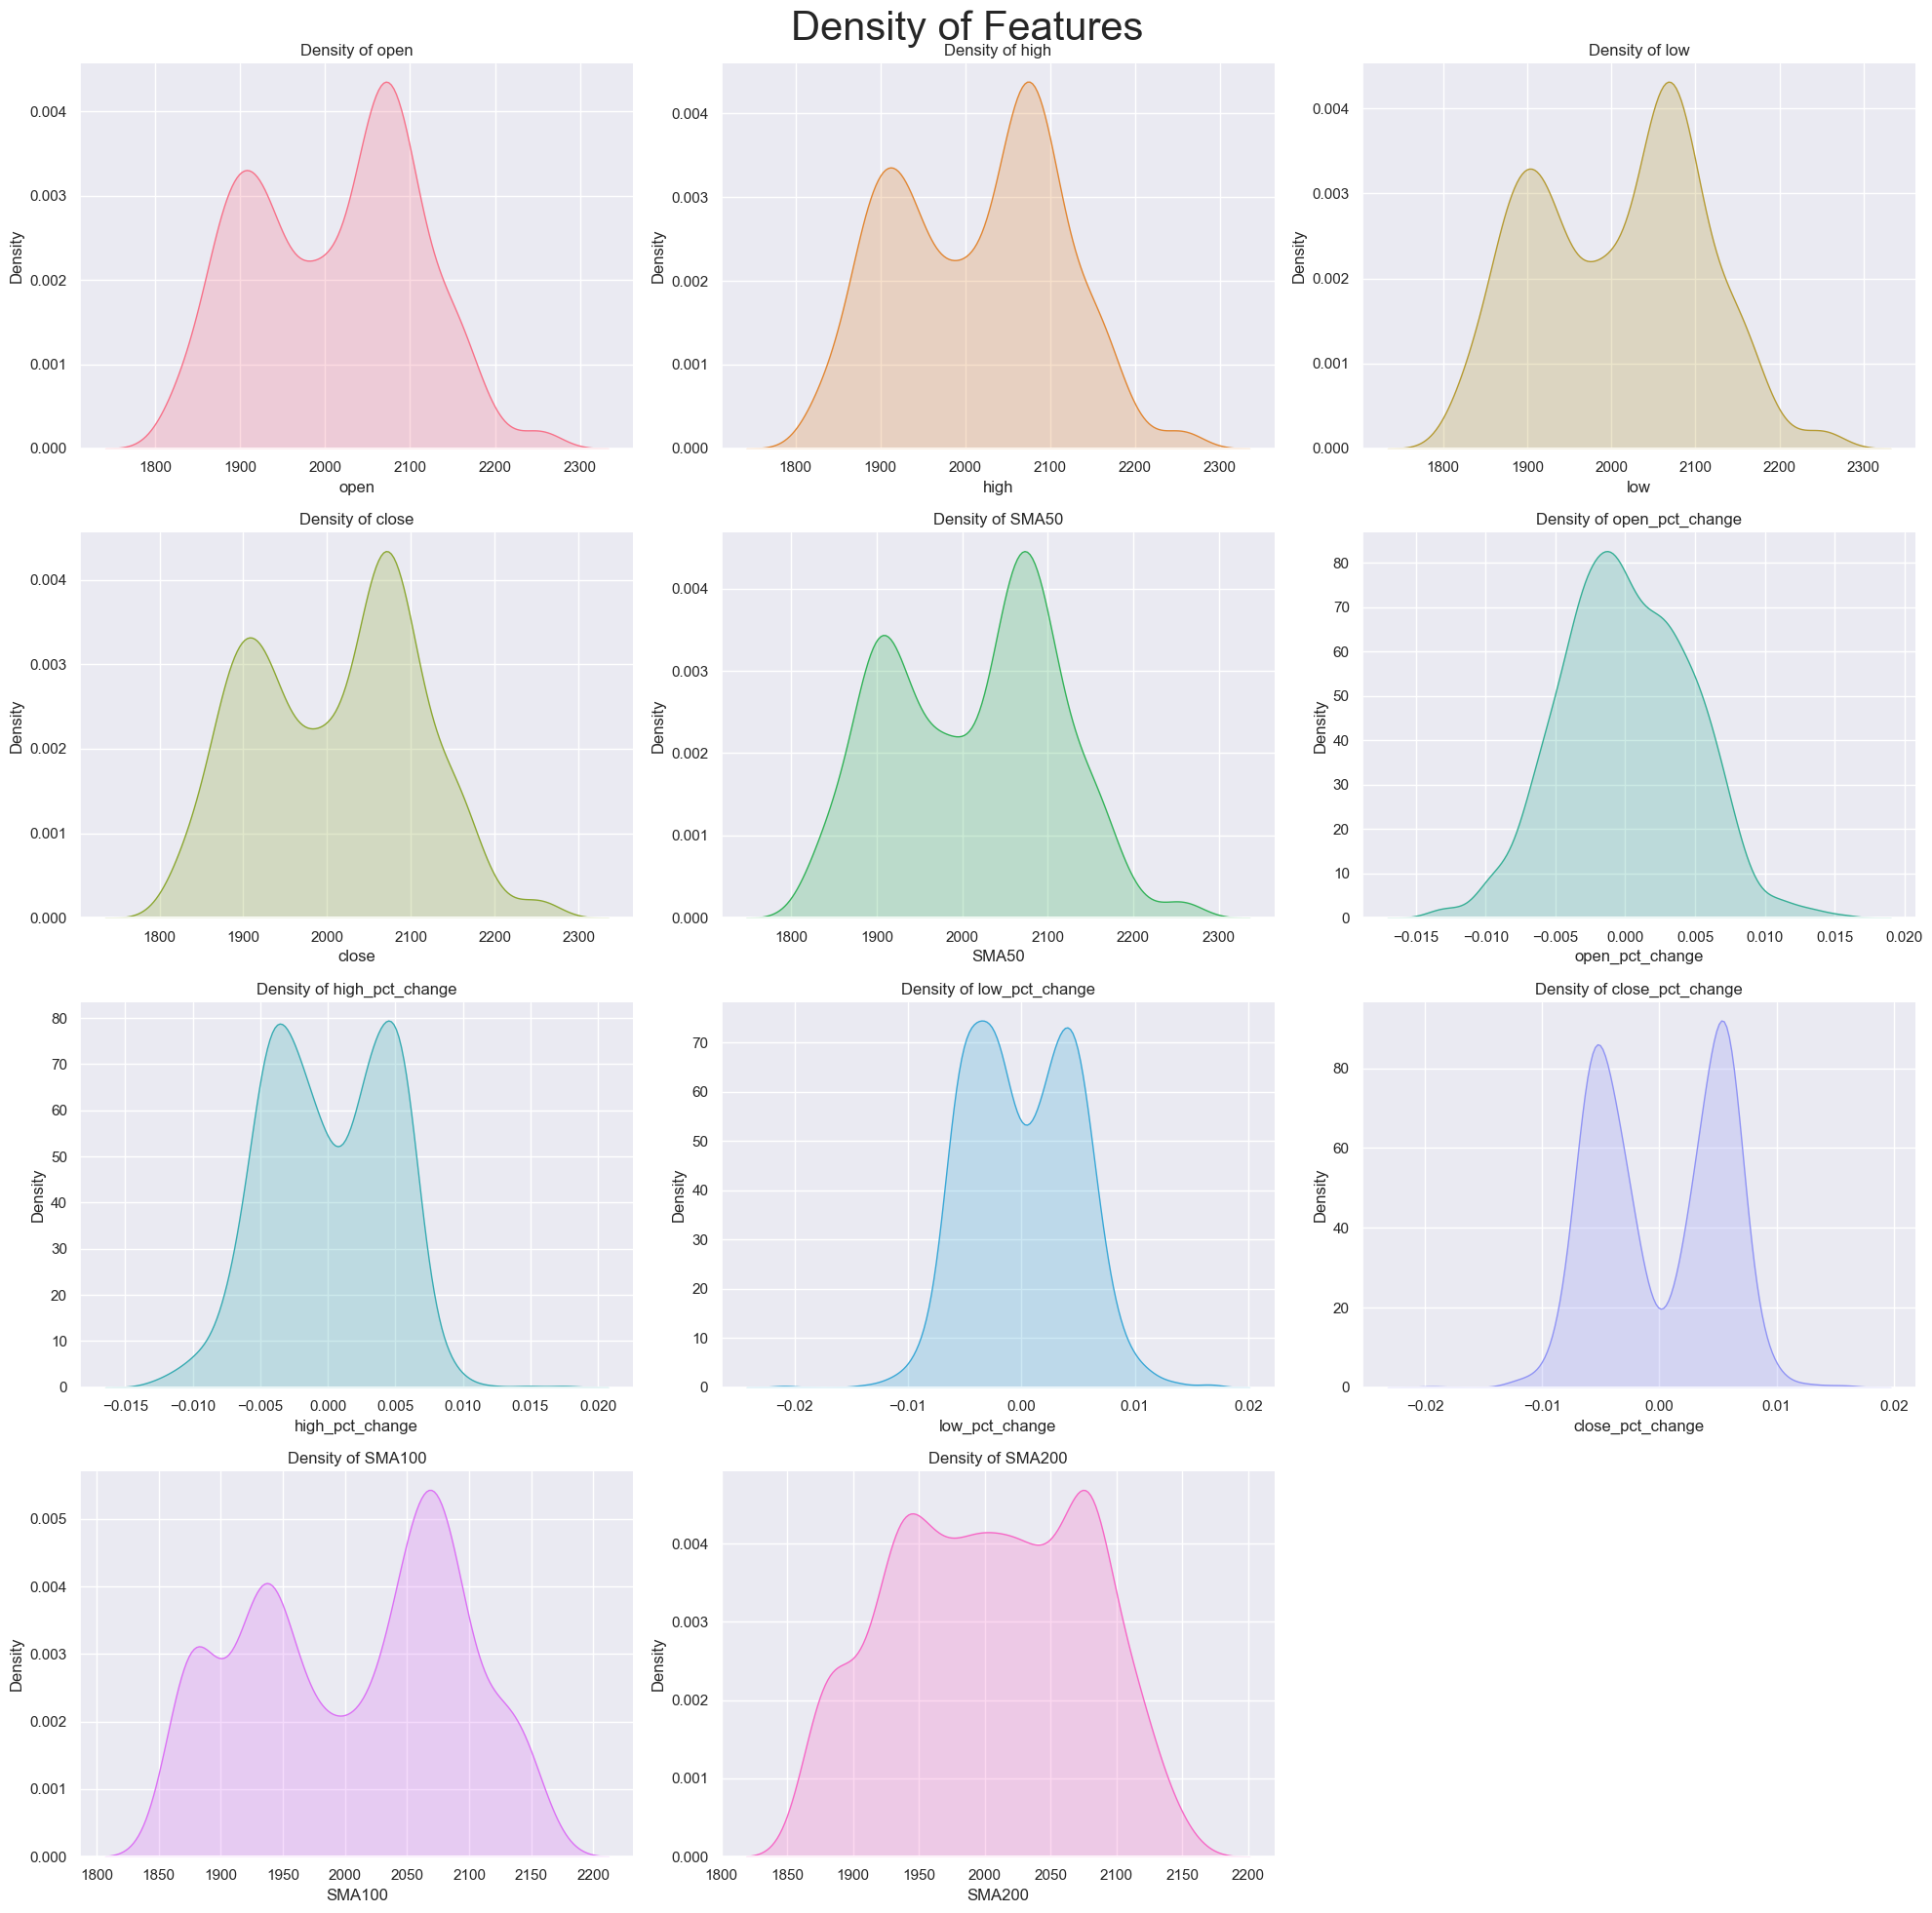

In [34]:
# high-level visualizations of the data: Viewing the density of the features

# Assuming data_ml is already defined and contains the vis_cols
vis_cols = ['open', 'high', 'low', 'close', 'SMA50', 'open_pct_change', 'high_pct_change', 'low_pct_change', 'close_pct_change', 'SMA100', 'SMA200']

# Generate a color palette with a different color for each subplot
palette = sns.color_palette('husl', len(vis_cols))

# Plotting the density of the features
plt.figure(figsize=(20, 20))
for i, (col, color) in enumerate(zip(vis_cols, palette)):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(data_ml[col], fill=True, color=color)
    plt.title(f'Density of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    sns.despine()

# Adding title
plt.suptitle('Density of Features', fontsize=30)

# Adjust the layout
plt.tight_layout()

# displaying the plot
plt.show()


In [35]:
# splitting the data into features and labels. I will be predicting the 'bin' column all other columns in the 'data_ml' dataframe will be the features
X = data_ml.drop(columns='bin')
y = data_ml['bin']

# checking the shape of X and y
print(X.shape)
print(y.shape)

(1316, 16)
(1316,)


In [36]:
# importing required libraries for the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [37]:
# splitting the data into training and testing datasets using a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instantiating the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# fitting the model on the training dataset
model.fit(X_train, y_train)

# making predictions on the testing dataset
y_pred = model.predict(X_test)


In [38]:
# calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# printing the accuracy
print(f'The accuracy of the model is: {accuracy:.2f}')

# printing the classification report
print(classification_report(y_test, y_pred))


The accuracy of the model is: 0.54
              precision    recall  f1-score   support

           0       0.56      0.63      0.59       207
           1       0.52      0.44      0.48       188

    accuracy                           0.54       395
   macro avg       0.54      0.54      0.53       395
weighted avg       0.54      0.54      0.54       395



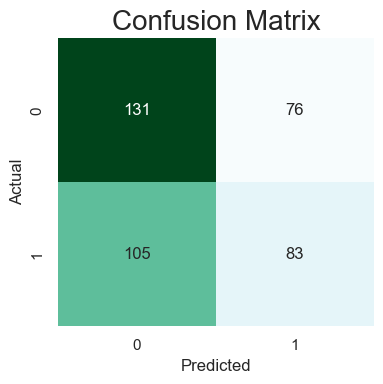

In [39]:
# creating a confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# plotting the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='BuGn', cbar=False)
plt.title('Confusion Matrix', fontsize=20)
plt.tight_layout()
plt.show()

# closing the plot
plt.close()

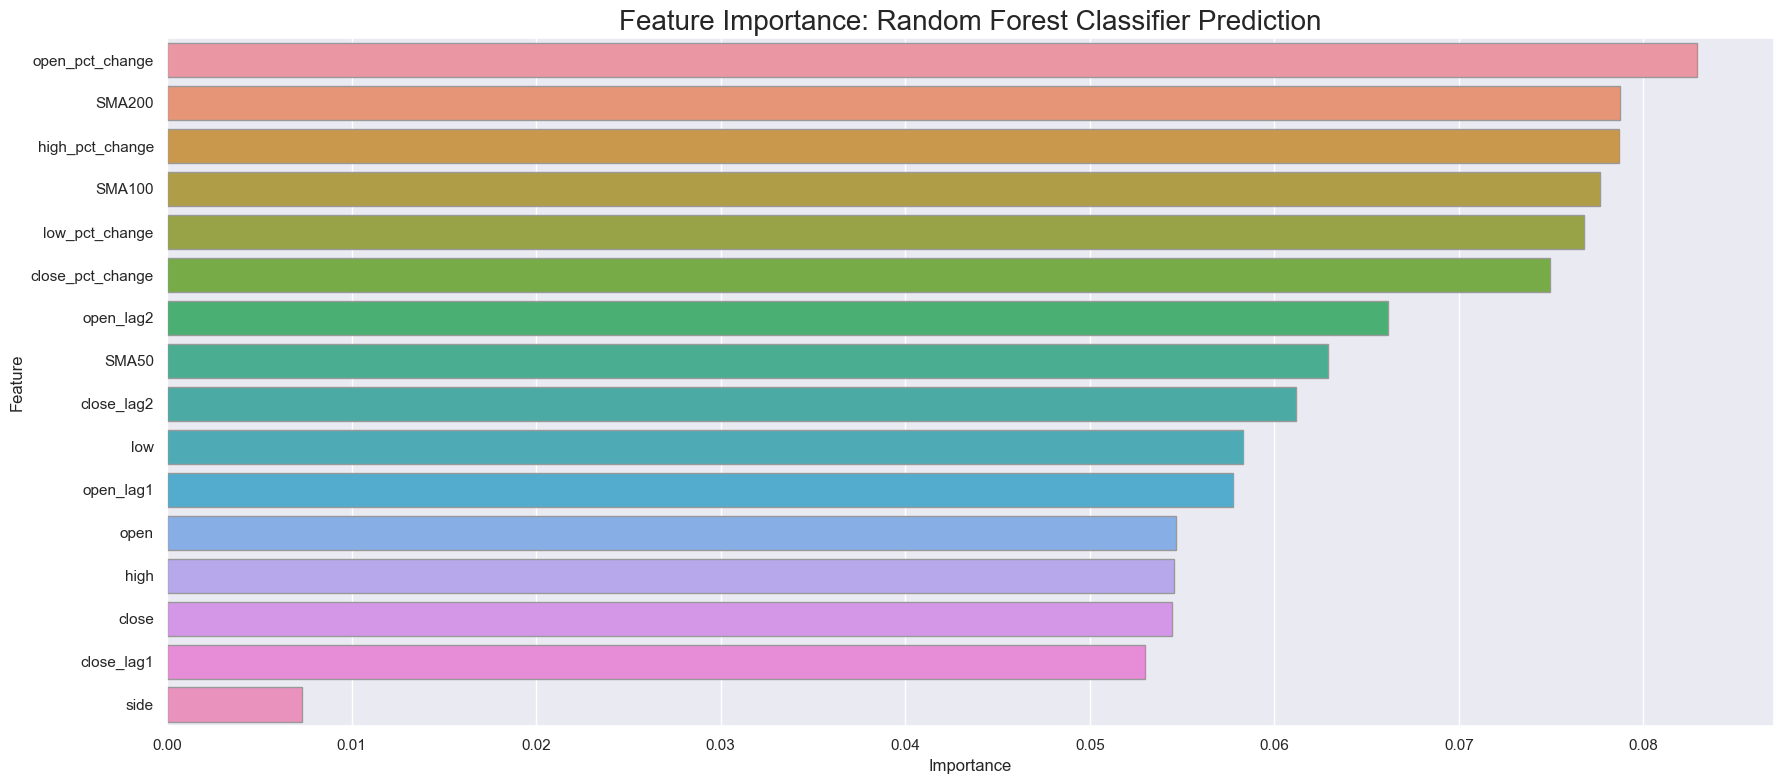

In [40]:
# checking the feature importance
feature_importance = model.feature_importances_

# creating a dataframe of the feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# sorting the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plotting the feature importance
# setting the style and palette
sns.set_context('notebook')
sns.set_style('darkgrid')
plt.figure(figsize=(18, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, edgecolor='0.6')
plt.title('Feature Importance: Random Forest Classifier Prediction', fontsize=20)
plt.tight_layout()
plt.show()

# closing the plot
plt.close()


In [41]:
# hyper tuning the model

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [42]:
# Instantiate the model
rf = RandomForestClassifier(random_state=42)

# Instantiate the Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require I

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [43]:
# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'The accuracy of the tuned model is: {accuracy:.2f}')

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
The accuracy of the tuned model is: 0.55
              precision    recall  f1-score   support

           0       0.56      0.65      0.61       207
           1       0.54      0.45      0.49       188

    accuracy                           0.55       395
   macro avg       0.55      0.55      0.55       395
weighted avg       0.55      0.55      0.55       395

